# Spaceship Titanic Dataset with TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the Spaceship Titanic dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

# Import the library

In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [143]:
print("ScikitLearn v" + sklearn.__version__)

ScikitLearn v1.5.1


# Load the Dataset

In [144]:
# Load a dataset into a Pandas Dataframe
df_train = pd.read_csv('train.csv')
print("Full train dataset shape is {}".format(df_train.shape))

Full train dataset shape is (8693, 14)


The data is composed of 14 columns and 8693 entries. We can see all 14 dimensions of our dataset by printing out the first 5 entries using the following code:

In [145]:
# Display the first 5 examples
df_train.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


There are 12 feature columns. Using these features your model has to predict whether the passenger is rescued or not indicated by the column `Transported`.

# Let us quickly do a basic exploration of the dataset

In [146]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [147]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# Feature engineering

As we see almost all features (but PassengerId and Transported) got null values. Let's look at the picture in details.

In [148]:
df_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

As we know some of the passengers were travelling in group, so they'd got the same HomePlanet and Destination. Let's see how many unique HomePlanets and Destination there are in dataset.

So we need to know are there any intersected groups in train and test sets.

In [149]:
df_test = pd.read_csv('test.csv')
df_test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


In [150]:
df_test['Transported'] = np.nan

In [151]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,NaN
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,NaN
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,NaN
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,NaN
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,NaN


Let`s combine two datasets to minimize number of NaN valued HomePlanet and Destination. Separation of two datasets will be provided by NaN value of Transported.

In [152]:
combined_df = pd.concat([df_train, df_test], axis=0)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


In [153]:
print(f"Unique HomePlanets: {combined_df.HomePlanet.unique()}")
print(f"Unique Destinations: {combined_df.Destination.unique()}")

Unique HomePlanets: ['Europa' 'Earth' 'Mars' nan]
Unique Destinations: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]


Let`s substitute PassengerId by two columns PassengerGroup and IngroupNum.

In [154]:
combined_df[["PassengerGroup", "IngroupNum"]] = combined_df["PassengerId"].str.split("_", expand=True).astype(int)
try:
    combined_df.drop(columns=["PassengerId"], inplace=True)
except KeyError:
    print("Already removed PassengerId")


In [155]:
combined_df.HomePlanet.isna().sum()

288

In [156]:

def fill_homes(row):
    if pd.isna(row.HomePlanet):
        group_count = combined_df[combined_df.PassengerGroup == row.PassengerGroup].IngroupNum.count()
        if group_count > 1:
            try:
                home_planet = combined_df[combined_df.PassengerGroup == row.PassengerGroup].HomePlanet.mode().values[0]
            except IndexError:
                return row
            row.HomePlanet = home_planet
    return row

combined_df = combined_df.apply(fill_homes, axis=1)

combined_df.HomePlanet.isna().sum()

157

In [157]:
combined_df.Destination.isna().sum()

274

In [158]:
def fill_dests(row):
    if pd.isna(row.Destination):
        group_count = combined_df[combined_df.PassengerGroup == row.PassengerGroup].IngroupNum.count()
        if group_count > 1:
            try:
                destination = combined_df[combined_df.PassengerGroup == row.PassengerGroup].Destination.mode().values[0]
            except IndexError:
                return row
            row.Destination = destination
    return row

combined_df = combined_df.apply(fill_dests, axis=1)

combined_df.Destination.isna().sum()

154

We've reduced number of uncertain HomePlanets from 288 to 157 and Destinations from 274 to 154

# Numerical data distribution

Let us plot all the numerical columns and their value counts:

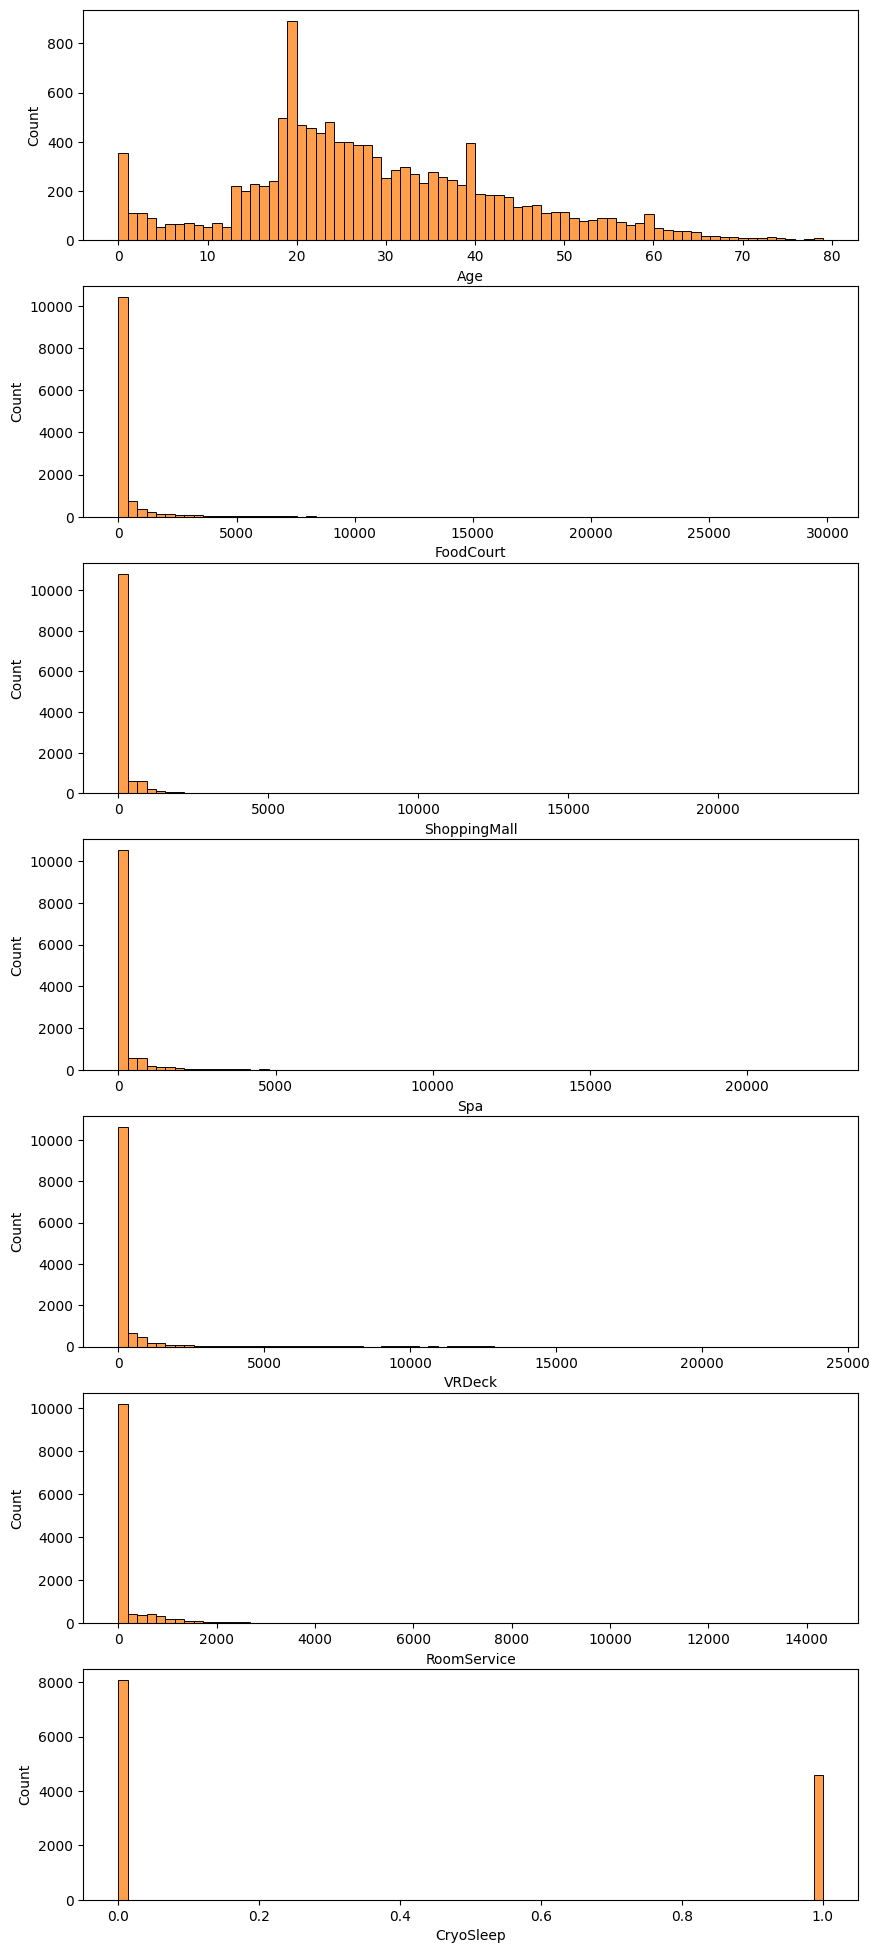

In [159]:
fig, ax = plt.subplots(7,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(combined_df['Age'], color='C1', bins=75, ax=ax[0]);
sns.histplot(combined_df['FoodCourt'], color='C1', bins=75, ax=ax[1]);
sns.histplot(combined_df['ShoppingMall'], color='C1', bins=75, ax=ax[2]);
sns.histplot(combined_df['Spa'], color='C1', bins=75, ax=ax[3]);
sns.histplot(combined_df['VRDeck'], color='C1', bins=75, ax=ax[4]);
sns.histplot(combined_df['RoomService'], color='C1', bins=75, ax=ax[5]);
sns.histplot(combined_df['CryoSleep'], color='C1', bins=75, ax=ax[6]);

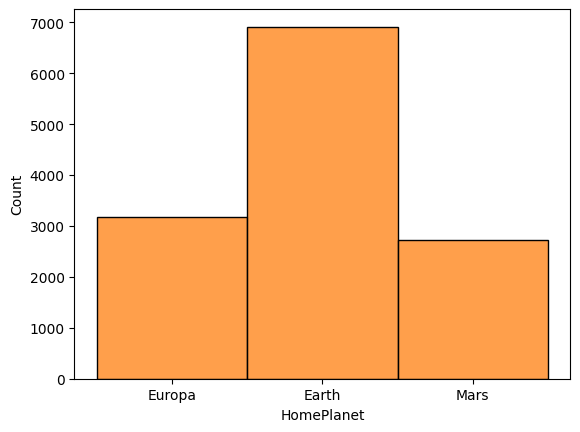

In [160]:
sns.histplot(combined_df.HomePlanet, color='C1');

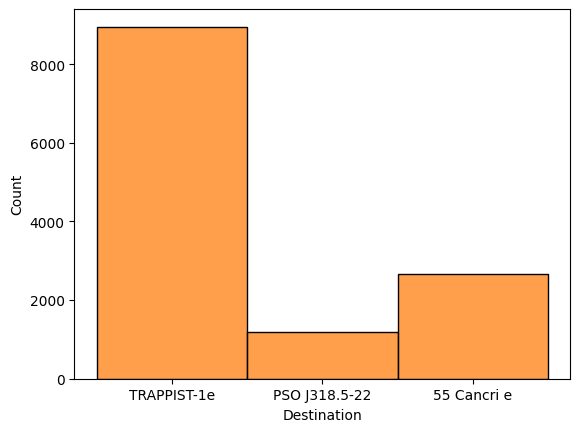

In [161]:
sns.histplot(combined_df.Destination, color='C1');

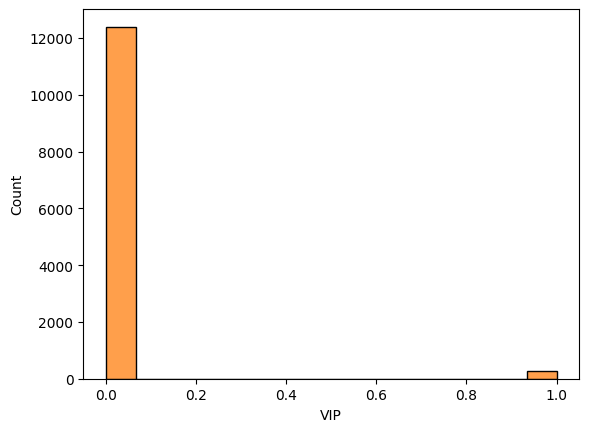

In [162]:
sns.histplot(combined_df.VIP, color='C1');

In [163]:
from sklearn.impute import SimpleImputer

mode_imputer = SimpleImputer(strategy='most_frequent')
mode_columns = ['HomePlanet', 'Destination', 'VIP', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']
combined_df[mode_columns] = mode_imputer.fit_transform(combined_df[mode_columns])


Passenger in CryoSleep could not spent money, so let assume that passenger with NaN CryoSleep who's got no spendings in FoodCourt, ShoppingMall, Spa, VRDeck, RoomService is in CryoSleep and vice versa.

In [164]:
def cryo_cant_byu(row):
    if isinstance(row['CryoSleep'], bool):
        return row
    bought = row[['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']].sum()
    if bought == 0:
        row['CryoSleep'] = True
    else:
        row['CryoSleep'] = False
    return row

combined_df = combined_df.apply(cryo_cant_byu, axis=1)

In [165]:
combined_df.isna().sum()

HomePlanet           0
CryoSleep            0
Cabin              299
Destination          0
Age                270
VIP                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Name               294
Transported       4277
PassengerGroup       0
IngroupNum           0
dtype: int64

# Prepare the dataset

We will drop both `PassengerId` and `Name` columns as they are not necessary for model training.

In [ ]:
df_train = df_train.drop(['PassengerId', 'Name'], axis=1)
df_train.head(5)

We will check for the missing values using the following code:

In [ ]:
df_train.isnull().sum().sort_values(ascending=False)

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required.

But this datatset also has boolean fields with missing values. TF-DF doesn't support boolean fields yet. So we need to convert those fields into int. To account for the missing values in the boolean fields, we will replace them with zero.

In this notebook, we will replace null value entries with zero for numerical columns as well and only let TF-DF handle the missing values in categorical columns.

Note: You can choose to let TF-DF handle missing values in numerical columns if need be.

In [13]:
df_train[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df_train[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
df_train.isnull().sum().sort_values(ascending=False)

HomePlanet      201
Name            200
Cabin           199
Destination     182
RoomService     181
Age             179
PassengerId       0
CryoSleep         0
VIP               0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

Since, TF-DF cannot handle boolean columns, we will have to adjust the labels in column `Transported` to convert them into the integer format that TF-DF expects.

In [ ]:
label = "Transported"
df_train[label] = df_train[label].astype(int)

We will also convert the boolean fields `CryoSleep` and `VIP` to int.

In [ ]:
df_train['VIP'] = df_train['VIP'].astype(int)
df_train['CryoSleep'] = df_train['CryoSleep'].astype(int)

The value of column `Cabin` is a string with the format `Deck/Cabin_num/Side`. Here we will split the `Cabin` column and create 3 new columns `Deck`, `Cabin_num` and `Side`, since it will be easier to train the model on those individual data.

Run the following command to split the column `Cabin` into columns `Deck`, `Cabin_num` and `Side`

In [ ]:
df_train[["Deck", "Cabin_num", "Side"]] = df_train["Cabin"].str.split("/", expand=True)

Remove original `Cabin` column from the dataset since it's not needed anymore.

In [ ]:
try:
    df_train = df_train.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")

Let us display the first 5 examples from the prepared dataset.

In [ ]:
df_train.head(5)

Now let us split the dataset into training and testing datasets:

In [ ]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(df_train)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

In [ ]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label)

# Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [ ]:
tfdf.keras.get_all_models()

# Configure the model

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

# Create a Random Forest

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.

In [ ]:
rf = tfdf.keras.RandomForestModel()
rf.compile(metrics=["accuracy"]) # Optional, you can use this to include a list of eval metrics

# Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

In [ ]:
rf.fit(x=train_ds)

# Visualize the model
One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

In [ ]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

# Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training the dataset we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the accuracy evaluated on the out-of-bag dataset according to the number of trees in the model. Let us plot this.

Note: Larger values are better for this hyperparameter.

In [ ]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.show()

We can also see some general stats on the OOB dataset:

In [ ]:
inspector = rf.make_inspector()
inspector.evaluation()

Now, let us run an evaluation using the validation dataset.

In [ ]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

# Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [ ]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [ ]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

# Submission

In [ ]:
# Load the test dataset
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission_id = test_df.PassengerId

# Replace NaN values with zero
test_df[['VIP', 'CryoSleep']] = test_df[['VIP', 'CryoSleep']].fillna(value=0)

# Creating New Features - Deck, Cabin_num and Side from the column Cabin and remove Cabin
test_df[["Deck", "Cabin_num", "Side"]] = test_df["Cabin"].str.split("/", expand=True)
test_df = test_df.drop('Cabin', axis=1)

# Convert boolean to 1's and 0's
test_df['VIP'] = test_df['VIP'].astype(int)
test_df['CryoSleep'] = test_df['CryoSleep'].astype(int)

# Convert pd dataframe to tf dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df)

# Get the predictions for testdata
predictions = rf.predict(test_ds)
n_predictions = (predictions > 0.5).astype(bool)
output = pd.DataFrame({'PassengerId': submission_id,
                       'Transported': n_predictions.squeeze()})

output.head()

In [ ]:
sample_submission_df = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
sample_submission_df['Transported'] = n_predictions
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()